# Title of your assignment

#### Student no : 21727432
#### Student name : Ali KAYADİBİ

## Table of Content

[Purpose](#purpose)   
[Data Understanding](#data_understanding)   
[Data Preparation](#data_preparation)   
[Modeling for Clustering](#clusteringmodel)  
[Clustering results](#clustering)    
[Modeling for Classification](#classificationmodel)  
[Evaluation](#evaluation)  
[References](#references)   


## Purpose <a class="anchor" id="purpose"></a>


Describe the aim of this assigment here. What are the questions you are trying to solve?

In this assignment our goal is to get familiar with data preparing,feature selection, normalization, clustering and classifying topics with using PySpark Environment.
Our data consist of features of haricot bean species and we are trying machine learning methods to classify given beans.
We should be able to predict the types of these beans with most accurate ways by using clustering and classification methods.
We are expected to be familiar with the basics of Apache Spark and
machine learning methods using the Spark Environment.


In [1]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [56.8 kB]
Hit:12 http://ppa.launchpad.net/cran/

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets.samples_generator import make_blobs
from pyspark import SparkContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext

%matplotlib inline


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


## Data Understanding<a class="anchor" id="data_understanding"></a>


Lets examine the data cell by cell to find out data count, data types and much more about these dataset.

In [5]:
import pyspark

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

df = spark.read.csv("data.csv", header = True, inferSchema = True)

InferSchema automatically detects the type of the column and assign the type, header specifies that first row is not data , it includes headers. 


PrintSchema can show the types of columns in dataset.

In [6]:
df.printSchema()

root
 |-- Area: integer (nullable = true)
 |-- Perimeter: double (nullable = true)
 |-- MajorAxisLength: double (nullable = true)
 |-- MinorAxisLength: double (nullable = true)
 |-- AspectRation: double (nullable = true)
 |-- Eccentricity: double (nullable = true)
 |-- ConvexArea: integer (nullable = true)
 |-- EquivDiameter: double (nullable = true)
 |-- Extent: double (nullable = true)
 |-- Solidity: double (nullable = true)
 |-- roundness: double (nullable = true)
 |-- Compactness: double (nullable = true)
 |-- ShapeFactor1: double (nullable = true)
 |-- ShapeFactor2: double (nullable = true)
 |-- ShapeFactor3: double (nullable = true)
 |-- ShapeFactor4: double (nullable = true)
 |-- Class: string (nullable = true)



In [7]:
print(df.count())

13611


This is the total num of rows we have.


Lets see how our data looks.

In [8]:
df.show(5)

+-----+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+
| Area|Perimeter|MajorAxisLength|MinorAxisLength|AspectRation|Eccentricity|ConvexArea|EquivDiameter|     Extent|   Solidity|  roundness|Compactness|ShapeFactor1|ShapeFactor2|ShapeFactor3|ShapeFactor4|Class|
+-----+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+
|28395|  610.291|    208.1781167|     173.888747| 1.197191424| 0.549812187|     28715|  190.1410973|0.763922518|0.988855999|0.958027126|0.913357755| 0.007331506| 0.003147289| 0.834222388| 0.998723889|SEKER|
|28734|  638.018|    200.5247957|    182.7344194| 1.097356461| 0.411785251|     29172|  191.2727505|0.783968133|0.984985603|0.887033637|0.953860842| 0.006978659| 0.00356362

In [9]:
df.describe().show()

+-------+------------------+------------------+-----------------+-----------------+-------------------+-------------------+------------------+------------------+--------------------+------------------+-------------------+-------------------+--------------------+--------------------+------------------+--------------------+--------+
|summary|              Area|         Perimeter|  MajorAxisLength|  MinorAxisLength|       AspectRation|       Eccentricity|        ConvexArea|     EquivDiameter|              Extent|          Solidity|          roundness|        Compactness|        ShapeFactor1|        ShapeFactor2|      ShapeFactor3|        ShapeFactor4|   Class|
+-------+------------------+------------------+-----------------+-----------------+-------------------+-------------------+------------------+------------------+--------------------+------------------+-------------------+-------------------+--------------------+--------------------+------------------+--------------------+--------+
|

## Data Preparation<a class="anchor" id="data_preparation"></a>

As we see we can get these informations about the data using these Pyspark dataframe functions provided to us.They are very helpful to understand the data.

Now we will prepare our data to use in classification and clustering models. We will use original and normalized dataset seperately. One of them is original data set the other one is normalized data set. We will compare the results we get from using these datasets in clustering and classifying methods. I will try the method i have learned during this assignment. It is storing both normalized and original data in one PySpark dataframe and selecting wanted columns from that DataFrame. By doing that i only have one Dataframe it is less confusing so i wanted to try that method.

In [10]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol = "Class", outputCol = "Label")

indexer = indexer.fit(df)

df = indexer.transform(df)

df = df.drop("Class")
df.show(5)

+-----+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+
| Area|Perimeter|MajorAxisLength|MinorAxisLength|AspectRation|Eccentricity|ConvexArea|EquivDiameter|     Extent|   Solidity|  roundness|Compactness|ShapeFactor1|ShapeFactor2|ShapeFactor3|ShapeFactor4|Label|
+-----+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+
|28395|  610.291|    208.1781167|     173.888747| 1.197191424| 0.549812187|     28715|  190.1410973|0.763922518|0.988855999|0.958027126|0.913357755| 0.007331506| 0.003147289| 0.834222388| 0.998723889|  2.0|
|28734|  638.018|    200.5247957|    182.7344194| 1.097356461| 0.411785251|     29172|  191.2727505|0.783968133|0.984985603|0.887033637|0.953860842| 0.006978659| 0.00356362

We have no nan values so we skip that part.

Here i transformed String Class label to int Label table, because clusters and classifiying models use integer values. Giving string values will not work. Using string indexer helped me transform these string values to integer values.

In [11]:
print(df)

DataFrame[Area: int, Perimeter: double, MajorAxisLength: double, MinorAxisLength: double, AspectRation: double, Eccentricity: double, ConvexArea: int, EquivDiameter: double, Extent: double, Solidity: double, roundness: double, Compactness: double, ShapeFactor1: double, ShapeFactor2: double, ShapeFactor3: double, ShapeFactor4: double, Label: double]


In [12]:
features_columns = ["Area", "Perimeter", "MajorAxisLength", "MinorAxisLength", "AspectRation", "Eccentricity", "ConvexArea", "EquivDiameter", "Extent", "Solidity", "roundness", "Compactness", "ShapeFactor1", "ShapeFactor2", "ShapeFactor3", "ShapeFactor4"]

Here i store feature names because later i will need them to select between original dataset and normalized dataset.These columns are responsible from original dataset.

In [13]:
from pyspark.ml.linalg import Vectors # !!!!caution: not from pyspark.mllib.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString,StringIndexer, VectorIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def transData(data):
    return data.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','Label'])

In here transData method is transferring all the features into vector which is main way of doing things with PySpark. Classification and clustering methods work with vectors and output columns.

I have learned that we should split first, than we normalize the data so we will try this by splitting first.

Lets see the splitting datasets.

In [14]:
(trainingData, testData) = df.randomSplit([0.7, 0.3])
print(trainingData.count())
trainingData.show(5)

9521
+-----+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+
| Area|Perimeter|MajorAxisLength|MinorAxisLength|AspectRation|Eccentricity|ConvexArea|EquivDiameter|     Extent|   Solidity|  roundness|Compactness|ShapeFactor1|ShapeFactor2|ShapeFactor3|ShapeFactor4|Label|
+-----+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+
|20420|  524.932|     183.601165|    141.8862155| 1.294002834| 0.634654708|     20684|  161.2437642|0.790186518|0.987236511|0.931235461|0.878228437| 0.008991242| 0.003299358| 0.771285188|  0.99804522|  0.0|
|20548|  524.736|    183.9652515|    142.6723878| 1.289424354| 0.631298586|     20825|  161.7483421|0.759686483|0.986698679|0.937772948| 0.87923312| 0.008952952| 0.003

In [15]:
print(testData.count())
testData.show(5)

4090
+-----+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+
| Area|Perimeter|MajorAxisLength|MinorAxisLength|AspectRation|Eccentricity|ConvexArea|EquivDiameter|     Extent|   Solidity|  roundness|Compactness|ShapeFactor1|ShapeFactor2|ShapeFactor3|ShapeFactor4|Label|
+-----+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+
|20464|  528.408|     191.249312|    136.3684624| 1.402445321| 0.701123073|     20772|  161.4173908|0.747406866|0.985172347|0.921004226|0.844015537| 0.009345647| 0.002925438| 0.712362227| 0.999049071|  0.0|
|21314|  537.215|    193.9609965|    140.0814439| 1.384630191| 0.691669153|     21587|  164.7356296| 0.76208524|  0.9873535|0.928065363|0.849323486| 0.009100169| 0.002

Now i will normalize the training and the test data. The good thing is below code creates and add normalized columns to original data so in one dataframe we will have both original and normalized data. With using columns names ( original dataset is original column names, normalized column names is original+"_scaled" column names) by doing that i can easily give the same dataframe with different columns to clustering and classifiying methods.

In [16]:
from pyspark.ml.feature import MinMaxScaler
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

unlist = udf(lambda x: round(float(list(x)[0]),3), DoubleType())
selected_columns = []
for i in features_columns:
    # VectorAssembler Transformation - Converting column to vector type
    assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")

    # MinMaxScaler Transformation
    scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")

    # Pipeline of VectorAssembler and MinMaxScaler
    pipeline = Pipeline(stages=[assembler, scaler])

    # Fitting pipeline on dataframe
    trainingData = pipeline.fit(trainingData).transform(trainingData).withColumn(i+"_Scaled", unlist(i+"_Scaled")).drop(i+"_Vect")
    selected_columns.append(i+"_Scaled")
trainingData.show(5)

+-----+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+-----------+----------------+----------------------+----------------------+-------------------+-------------------+-----------------+--------------------+-------------+---------------+----------------+------------------+-------------------+-------------------+-------------------+-------------------+
| Area|Perimeter|MajorAxisLength|MinorAxisLength|AspectRation|Eccentricity|ConvexArea|EquivDiameter|     Extent|   Solidity|  roundness|Compactness|ShapeFactor1|ShapeFactor2|ShapeFactor3|ShapeFactor4|Label|Area_Scaled|Perimeter_Scaled|MajorAxisLength_Scaled|MinorAxisLength_Scaled|AspectRation_Scaled|Eccentricity_Scaled|ConvexArea_Scaled|EquivDiameter_Scaled|Extent_Scaled|Solidity_Scaled|roundness_Scaled|Compactness_Scaled|ShapeFactor1_Scaled|ShapeFactor2_Scaled|ShapeFactor3_Scaled|ShapeFa

As we see training and testing data is splitted and they are normalized in the same dataset. Their _scaled columns are normalized values of their dataset. It is better this way compared to assignment 2. Because with this way, training normalization tecnique do not know about test datas. This is much better way of normalizing because input and test does not interfere each other.

In [17]:
for i in features_columns:
    # VectorAssembler Transformation - Converting column to vector type
    assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")

    # MinMaxScaler Transformation
    scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")

    # Pipeline of VectorAssembler and MinMaxScaler
    pipeline = Pipeline(stages=[assembler, scaler])

    # Fitting pipeline on dataframe
    testData = pipeline.fit(testData).transform(testData).withColumn(i+"_Scaled", unlist(i+"_Scaled")).drop(i+"_Vect")
testData.show(5)

+-----+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+-----------+----------------+----------------------+----------------------+-------------------+-------------------+-----------------+--------------------+-------------+---------------+----------------+------------------+-------------------+-------------------+-------------------+-------------------+
| Area|Perimeter|MajorAxisLength|MinorAxisLength|AspectRation|Eccentricity|ConvexArea|EquivDiameter|     Extent|   Solidity|  roundness|Compactness|ShapeFactor1|ShapeFactor2|ShapeFactor3|ShapeFactor4|Label|Area_Scaled|Perimeter_Scaled|MajorAxisLength_Scaled|MinorAxisLength_Scaled|AspectRation_Scaled|Eccentricity_Scaled|ConvexArea_Scaled|EquivDiameter_Scaled|Extent_Scaled|Solidity_Scaled|roundness_Scaled|Compactness_Scaled|ShapeFactor1_Scaled|ShapeFactor2_Scaled|ShapeFactor3_Scaled|ShapeFa

In [18]:
for i in features_columns:
    # VectorAssembler Transformation - Converting column to vector type
    assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")

    # MinMaxScaler Transformation
    scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")

    # Pipeline of VectorAssembler and MinMaxScaler
    pipeline = Pipeline(stages=[assembler, scaler])

    # Fitting pipeline on dataframe
    df = pipeline.fit(df).transform(df).withColumn(i+"_Scaled", unlist(i+"_Scaled")).drop(i+"_Vect")
df.show(5)

+-----+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+-----------+----------------+----------------------+----------------------+-------------------+-------------------+-----------------+--------------------+-------------+---------------+----------------+------------------+-------------------+-------------------+-------------------+-------------------+
| Area|Perimeter|MajorAxisLength|MinorAxisLength|AspectRation|Eccentricity|ConvexArea|EquivDiameter|     Extent|   Solidity|  roundness|Compactness|ShapeFactor1|ShapeFactor2|ShapeFactor3|ShapeFactor4|Label|Area_Scaled|Perimeter_Scaled|MajorAxisLength_Scaled|MinorAxisLength_Scaled|AspectRation_Scaled|Eccentricity_Scaled|ConvexArea_Scaled|EquivDiameter_Scaled|Extent_Scaled|Solidity_Scaled|roundness_Scaled|Compactness_Scaled|ShapeFactor1_Scaled|ShapeFactor2_Scaled|ShapeFactor3_Scaled|ShapeFa

Here i am doing the same thing to full dataset because i want to use it on clustering. Clustering should be done on full dataset. Both the original and normalized values are in the same dataframe. But their columns are different and we will access these values with these columns.

In [19]:
selected_columns

['Area_Scaled',
 'Perimeter_Scaled',
 'MajorAxisLength_Scaled',
 'MinorAxisLength_Scaled',
 'AspectRation_Scaled',
 'Eccentricity_Scaled',
 'ConvexArea_Scaled',
 'EquivDiameter_Scaled',
 'Extent_Scaled',
 'Solidity_Scaled',
 'roundness_Scaled',
 'Compactness_Scaled',
 'ShapeFactor1_Scaled',
 'ShapeFactor2_Scaled',
 'ShapeFactor3_Scaled',
 'ShapeFactor4_Scaled']

In [20]:
features_columns

['Area',
 'Perimeter',
 'MajorAxisLength',
 'MinorAxisLength',
 'AspectRation',
 'Eccentricity',
 'ConvexArea',
 'EquivDiameter',
 'Extent',
 'Solidity',
 'roundness',
 'Compactness',
 'ShapeFactor1',
 'ShapeFactor2',
 'ShapeFactor3',
 'ShapeFactor4']

Lets check if the columns are correct.These are the columns that we are going to use in classification and clustering methods. With these columns and select function i can take wanted part of PySpark frame easily.

I am also adding the label columns so that our algorithm will also have the label values and it will use it on training part and also in evaluating model performance part with different metrics and consufion matrix.

In [21]:
features_columns.append('Label')
selected_columns.append('Label')

In [22]:
original_data = df.select(features_columns)
normalized_data = df.select(selected_columns)

As we explained above, with using 2 different column name arrays(one for original one for normalized), i can seperate original data and normalized data with 2 lines of code.

In [23]:
X_train = trainingData.select(features_columns)
nX_train = trainingData.select(selected_columns)
X_test = testData.select(features_columns)
nX_test = testData.select(selected_columns)

Here also seperating x and normalized with with on the same training data. Same for test data. In pyspark we dont need y_train and y_test because models take the output  column from their parameters.


Now lets check these created test and training datasets.

In [24]:
X_train.show(5)

+-----+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+
| Area|Perimeter|MajorAxisLength|MinorAxisLength|AspectRation|Eccentricity|ConvexArea|EquivDiameter|     Extent|   Solidity|  roundness|Compactness|ShapeFactor1|ShapeFactor2|ShapeFactor3|ShapeFactor4|Label|
+-----+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+
|20420|  524.932|     183.601165|    141.8862155| 1.294002834| 0.634654708|     20684|  161.2437642|0.790186518|0.987236511|0.931235461|0.878228437| 0.008991242| 0.003299358| 0.771285188|  0.99804522|  0.0|
|20548|  524.736|    183.9652515|    142.6723878| 1.289424354| 0.631298586|     20825|  161.7483421|0.759686483|0.986698679|0.937772948| 0.87923312| 0.008952952| 0.00330036

In [25]:
nX_train.show(5)

+-----------+----------------+----------------------+----------------------+-------------------+-------------------+-----------------+--------------------+-------------+---------------+----------------+------------------+-------------------+-------------------+-------------------+-------------------+-----+
|Area_Scaled|Perimeter_Scaled|MajorAxisLength_Scaled|MinorAxisLength_Scaled|AspectRation_Scaled|Eccentricity_Scaled|ConvexArea_Scaled|EquivDiameter_Scaled|Extent_Scaled|Solidity_Scaled|roundness_Scaled|Compactness_Scaled|ShapeFactor1_Scaled|ShapeFactor2_Scaled|ShapeFactor3_Scaled|ShapeFactor4_Scaled|Label|
+-----------+----------------+----------------------+----------------------+-------------------+-------------------+-----------------+--------------------+-------------+---------------+----------------+------------------+-------------------+-------------------+-------------------+-------------------+-----+
|        0.0|             0.0|                   0.0|                 0.057|

In PySpark methods you need to convert PySpark dataframes to vectors to use in classification, clustering methods. This Transdata function is doing that, transferin dataframe to vector to use in machine learning methods.

In [26]:
transformed_X_train = transData(X_train)
transformed_X_train.show(5)

+--------------------+-----+
|            features|Label|
+--------------------+-----+
|[20420.0,524.932,...|  0.0|
|[20548.0,524.736,...|  0.0|
|[20711.0,525.413,...|  0.0|
|[20786.0,534.717,...|  0.0|
|[20942.0,530.683,...|  0.0|
+--------------------+-----+
only showing top 5 rows



In [27]:
transformed_nX_train = transData(nX_train)
transformed_nX_train.show(5)

+--------------------+-----+
|            features|Label|
+--------------------+-----+
|[0.0,0.0,0.0,0.05...|  0.0|
|[0.001,0.0,0.001,...|  0.0|
|[0.001,0.0,0.005,...|  0.0|
|[0.002,0.007,0.03...|  0.0|
|[0.002,0.004,0.01...|  0.0|
+--------------------+-----+
only showing top 5 rows



In [28]:
transformed_X_test = transData(X_test)
transformed_X_test.show(5)

+--------------------+-----+
|            features|Label|
+--------------------+-----+
|[20464.0,528.408,...|  0.0|
|[21314.0,537.215,...|  0.0|
|[21558.0,539.466,...|  0.0|
|[21570.0,538.454,...|  0.0|
|[21636.0,545.616,...|  0.0|
+--------------------+-----+
only showing top 5 rows



In [29]:
transformed_nX_test = transData(nX_test)
transformed_nX_test.show(5)

+--------------------+-----+
|            features|Label|
+--------------------+-----+
|[0.0,0.0,0.0,0.02...|  0.0|
|[0.004,0.006,0.00...|  0.0|
|[0.005,0.008,0.01...|  0.0|
|[0.005,0.007,0.01...|  0.0|
|[0.005,0.012,0.00...|  0.0|
+--------------------+-----+
only showing top 5 rows



In [30]:
transformed_original_data = transData(original_data)
transformed_original_data.show(5)

+--------------------+-----+
|            features|Label|
+--------------------+-----+
|[28395.0,610.291,...|  2.0|
|[28734.0,638.018,...|  2.0|
|[29380.0,624.11,2...|  2.0|
|[30008.0,645.884,...|  2.0|
|[30140.0,620.134,...|  2.0|
+--------------------+-----+
only showing top 5 rows



In [31]:
transformed_normalized_data = transData(normalized_data)
transformed_normalized_data.show(5)

+--------------------+-----+
|            features|Label|
+--------------------+-----+
|[0.034,0.059,0.04...|  2.0|
|[0.036,0.078,0.03...|  2.0|
|[0.038,0.068,0.05...|  2.0|
|[0.041,0.083,0.04...|  2.0|
|[0.042,0.065,0.03...|  2.0|
+--------------------+-----+
only showing top 5 rows



## Modeling for Clustering <a class="anchor" id="clusteringmodel"></a>


This is where i do clustering. I have used KMeans for clustering method because i have used kmeans in second assignment too. K means is easy to understand and easy to implement. How k means works is it randomly selects cluster centers, assigns the points to the nearest cluster point and calculates the sum of squared error and updates the cluster centers until it reach a point which has the lowest sum of squarred error. In this assignment our cluster size is 7.

I have also used Silhoutte score and sum of squared errors to evaluate the performance of clustering method.

This is with original data.

In [32]:
from pyspark.ml.evaluation import ClusteringEvaluator

kmeans = KMeans().setK(7).setSeed(1)
model = kmeans.fit(transformed_original_data)

# Make predictions
predictions = model.transform(transformed_original_data)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

wssse = model.computeCost(transformed_original_data)
print("Within Set Sum of Squared Errors = " + str(wssse))

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Within Set Sum of Squared Errors = 720469781934.4565
Silhouette with squared euclidean distance = 0.6951610092825534
Cluster Centers: 
[5.95488375e+04 9.59948527e+02 3.71630439e+02 2.06163058e+02
 1.82384394e+00 8.22184736e-01 6.04592012e+04 2.75100886e+02
 7.27856863e-01 9.85025624e-01 8.12402198e-01 7.43532605e-01
 6.27386843e-03 1.19221315e-03 5.55826053e-01 9.92903937e-01]
[1.76467618e+05 1.60501012e+03 6.03792202e+02 3.75566548e+02
 1.61099735e+00 7.79666729e-01 1.78850458e+05 4.73875119e+02
 7.77214216e-01 9.86701170e-01 8.60958322e-01 7.85912101e-01
 3.42461398e-03 8.08341869e-04 6.18437686e-01 9.91463254e-01]
[3.21004315e+04 6.62873920e+02 2.41909941e+02 1.69226649e+02
 1.43921071e+00 7.02701344e-01 3.24734842e+04 2.01760495e+02
 7.57375227e-01 9.88426374e-01 9.15119170e-01 8.35746221e-01
 7.60903527e-03 2.29575101e-03 7.00443577e-01 9.97127499e-01]
[7.81156758e+04 1.09056457e+03 4.09604789e+02 2.44705930e+02
 1.67967537e+00 7.96822639e-01 7.93683711e+04 3.15049249e+02
 7.54896

This is with normalized data.

This is the k means model we get using normalized data.We can call .clusterCenters to see the centers coordinates. It is multidimentional because we have 7 dimentions

In [33]:
kmeans = KMeans().setK(7).setSeed(1)
model = kmeans.fit(transformed_normalized_data)

# Make predictions
predictions = model.transform(transformed_normalized_data)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

wssse = model.computeCost(transformed_normalized_data)
print("Within Set Sum of Squared Errors = " + str(wssse))

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Within Set Sum of Squared Errors = 851.9660616353387
Silhouette with squared euclidean distance = 0.4888383761666875
Cluster Centers: 
[0.65360153 0.72644061 0.73757471 0.74584674 0.39889847 0.79645785
 0.63953257 0.75395211 0.7116341  0.89665709 0.74769157 0.43858046
 0.08654023 0.09037356 0.38780843 0.84830651]
[0.14394641 0.27500817 0.3429119  0.18492189 0.71235695 0.93674659
 0.14127157 0.24638965 0.29013261 0.87280291 0.59918619 0.17383106
 0.54814441 0.15425704 0.1441535  0.85118438]
[0.1019678  0.18380777 0.20560385 0.19876578 0.39020581 0.79470486
 0.09961774 0.18566604 0.61479766 0.90883176 0.78342929 0.4492923
 0.5214959  0.36061711 0.39739426 0.92147475]
[0.08110726 0.13543881 0.11696587 0.23340517 0.14972452 0.52020965
 0.07881716 0.15237445 0.7004354  0.94086348 0.90911702 0.74780302
 0.46781911 0.65081131 0.70858264 0.97225305]
[0.23055778 0.36875038 0.38347772 0.34852946 0.44779985 0.8261469
 0.22647923 0.35768769 0.64289992 0.85802039 0.67031193 0.39190974
 0.33700038 0

## Clustering results<a class="anchor" id="clustering"></a>

From these outputs i can see that k means on normalized dataset performed better when you look at the silhoutte score and sum of squared erros. we expected this because we expect normalized to perform better because it scales the values in [0 1] and this way data distrubutes better, outliers are limited, input variables will be modeled more realisticly.

Now i will try to show the relation between features and clusters using seaborn library.To do this i am creating a new Pandas dataframe using the labels predicted from normalized k means model, concating that with the normalized dataframe. 

In [34]:
predictions.show(5)

+--------------------+-----+----------+
|            features|Label|prediction|
+--------------------+-----+----------+
|[0.034,0.059,0.04...|  2.0|         3|
|[0.036,0.078,0.03...|  2.0|         3|
|[0.038,0.068,0.05...|  2.0|         3|
|[0.041,0.083,0.04...|  2.0|         3|
|[0.042,0.065,0.03...|  2.0|         3|
+--------------------+-----+----------+
only showing top 5 rows



In [35]:
df.show(5)

+-----+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+-----------+----------------+----------------------+----------------------+-------------------+-------------------+-----------------+--------------------+-------------+---------------+----------------+------------------+-------------------+-------------------+-------------------+-------------------+
| Area|Perimeter|MajorAxisLength|MinorAxisLength|AspectRation|Eccentricity|ConvexArea|EquivDiameter|     Extent|   Solidity|  roundness|Compactness|ShapeFactor1|ShapeFactor2|ShapeFactor3|ShapeFactor4|Label|Area_Scaled|Perimeter_Scaled|MajorAxisLength_Scaled|MinorAxisLength_Scaled|AspectRation_Scaled|Eccentricity_Scaled|ConvexArea_Scaled|EquivDiameter_Scaled|Extent_Scaled|Solidity_Scaled|roundness_Scaled|Compactness_Scaled|ShapeFactor1_Scaled|ShapeFactor2_Scaled|ShapeFactor3_Scaled|ShapeFa

Visualization with PySpark is too hard so i am converting to Pandas DataFrame and plotting the graphs using seaborn library.

In [36]:
predictions_pd = predictions.toPandas()
df_pandas = df.toPandas()

In [37]:
df_pandas['cluster_labels'] = predictions_pd['prediction']
df_pandas

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Label,Area_Scaled,Perimeter_Scaled,MajorAxisLength_Scaled,MinorAxisLength_Scaled,AspectRation_Scaled,Eccentricity_Scaled,ConvexArea_Scaled,EquivDiameter_Scaled,Extent_Scaled,Solidity_Scaled,roundness_Scaled,Compactness_Scaled,ShapeFactor1_Scaled,ShapeFactor2_Scaled,ShapeFactor3_Scaled,ShapeFactor4_Scaled,cluster_labels
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,2.0,0.034,0.059,0.044,0.152,0.123,0.478,0.033,0.071,0.671,0.923,0.935,0.787,0.593,0.833,0.751,0.981,3
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272751,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,2.0,0.036,0.078,0.030,0.178,0.052,0.278,0.035,0.074,0.736,0.872,0.793,0.904,0.547,0.967,0.885,0.975,3
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,2.0,0.038,0.068,0.053,0.158,0.132,0.496,0.037,0.079,0.717,0.932,0.915,0.774,0.582,0.801,0.736,0.987,3
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,2.0,0.041,0.083,0.049,0.178,0.092,0.404,0.041,0.084,0.731,0.762,0.827,0.830,0.552,0.855,0.800,0.894,3
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,2.0,0.042,0.065,0.033,0.201,0.026,0.166,0.040,0.085,0.701,0.950,0.988,0.952,0.511,1.000,0.942,0.989,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13606,42097,759.696,288.721612,185.944705,1.552728,0.765002,42508,231.515799,0.714574,0.990331,0.916603,0.801865,0.006858,0.001749,0.642988,0.998385,0.0,0.093,0.161,0.189,0.188,0.376,0.789,0.090,0.172,0.512,0.942,0.852,0.465,0.532,0.382,0.412,0.974,2
13607,42101,757.499,281.576392,190.713136,1.476439,0.735702,42494,231.526798,0.799943,0.990752,0.922015,0.822252,0.006688,0.001886,0.676099,0.998219,0.0,0.093,0.159,0.176,0.202,0.321,0.746,0.090,0.172,0.787,0.948,0.863,0.524,0.510,0.426,0.471,0.971,2
13608,42139,759.321,281.539928,191.187979,1.472582,0.734065,42569,231.631261,0.729932,0.989899,0.918424,0.822730,0.006681,0.001888,0.676884,0.996767,0.0,0.093,0.161,0.176,0.203,0.319,0.744,0.090,0.172,0.562,0.937,0.856,0.525,0.509,0.427,0.472,0.943,2
13609,42147,763.779,283.382636,190.275731,1.489326,0.741055,42667,231.653247,0.705389,0.987813,0.907906,0.817457,0.006724,0.001852,0.668237,0.995222,0.0,0.093,0.164,0.180,0.201,0.330,0.754,0.091,0.173,0.483,0.909,0.835,0.510,0.514,0.415,0.457,0.913,2


This is the final dataset it contains all the columns of original, normalized datasets. I can directly write the name of two column, give the cluster predicted output label and print the graph.

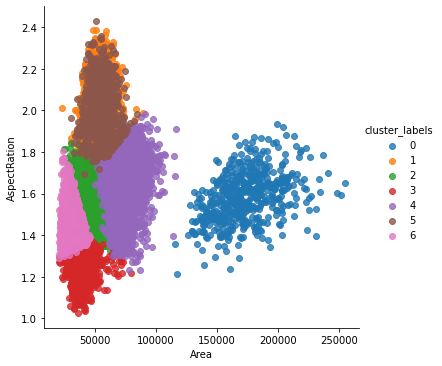

In [38]:
import seaborn as sns
sns.lmplot(x='Area',y='AspectRation',data=df_pandas,hue='cluster_labels',fit_reg=False)

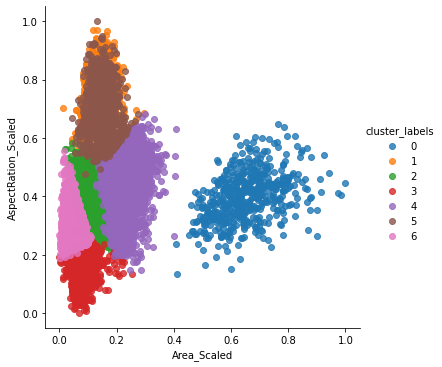

In [39]:
sns.lmplot(x='Area_Scaled',y='AspectRation_Scaled',data=df_pandas,hue='cluster_labels',fit_reg=False)

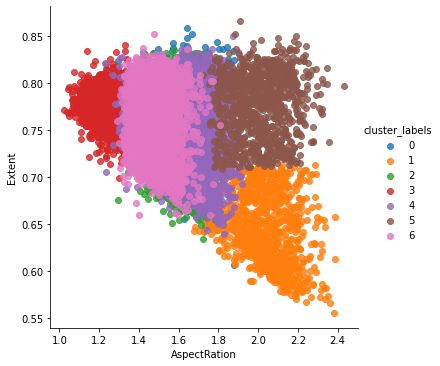

In [40]:
sns.lmplot(x='AspectRation',y='Extent',data=df_pandas,hue='cluster_labels',fit_reg=False)

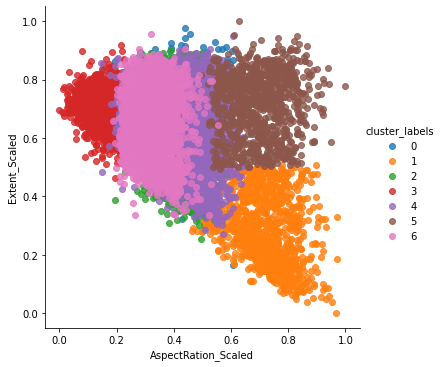

In [41]:
sns.lmplot(x='AspectRation_Scaled',y='Extent_Scaled',data=df_pandas,hue='cluster_labels',fit_reg=False)

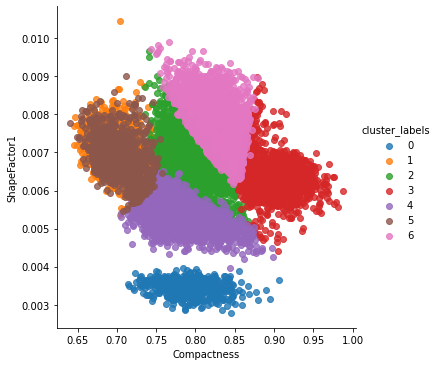

In [42]:
sns.lmplot(x='Compactness',y='ShapeFactor1',data=df_pandas,hue='cluster_labels',fit_reg=False)

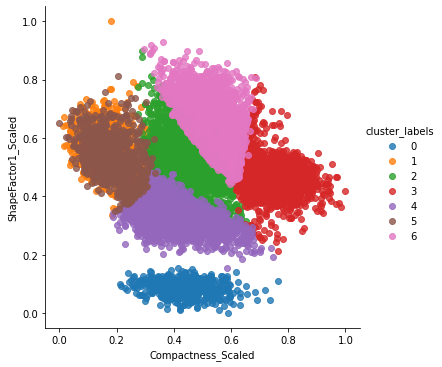

In [43]:
sns.lmplot(x='Compactness_Scaled',y='ShapeFactor1_Scaled',data=df_pandas,hue='cluster_labels',fit_reg=False)

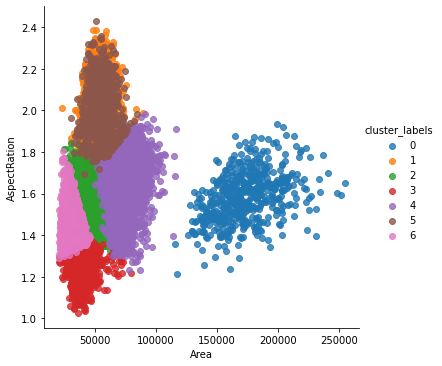

In [44]:
sns.lmplot(x='Area',y='AspectRation',data=df_pandas,hue='cluster_labels',fit_reg=False)

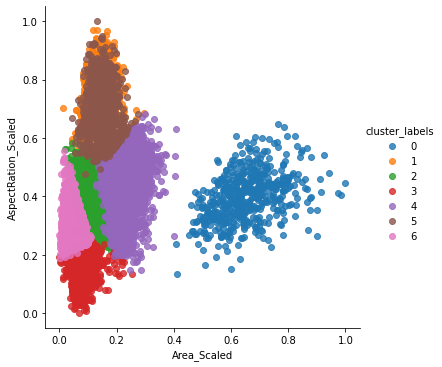

In [45]:
sns.lmplot(x='Area_Scaled',y='AspectRation_Scaled',data=df_pandas,hue='cluster_labels',fit_reg=False)

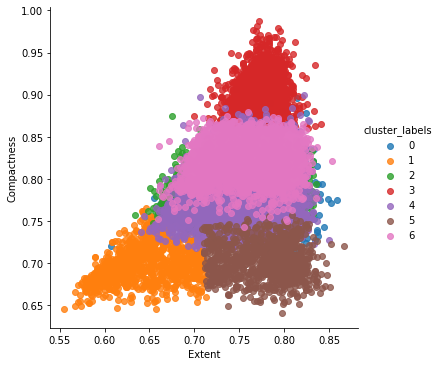

In [46]:
sns.lmplot(x='Extent',y='Compactness',data=df_pandas,hue='cluster_labels',fit_reg=False)

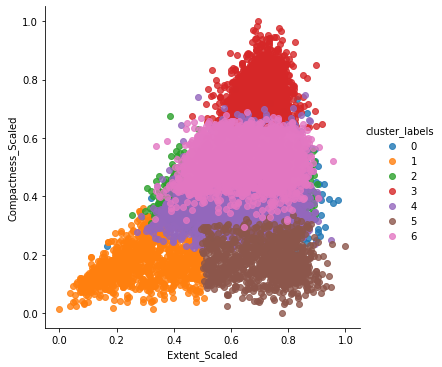

In [47]:
sns.lmplot(x='Extent_Scaled',y='Compactness_Scaled',data=df_pandas,hue='cluster_labels',fit_reg=False)

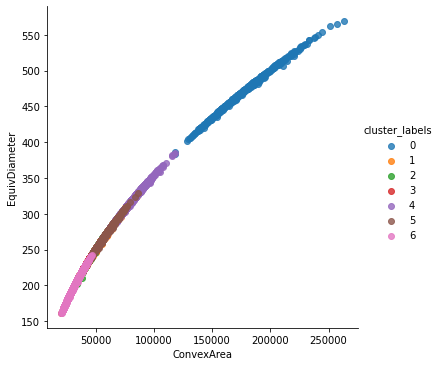

In [48]:
sns.lmplot(x='ConvexArea',y='EquivDiameter',data=df_pandas,hue='cluster_labels',fit_reg=False)

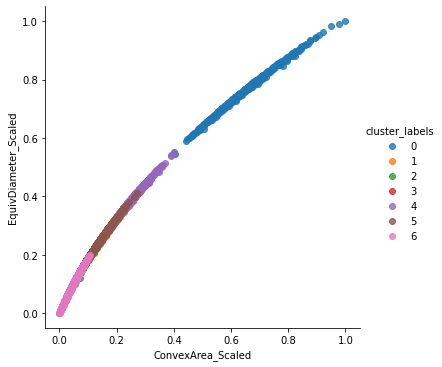

In [49]:
sns.lmplot(x='ConvexArea_Scaled',y='EquivDiameter_Scaled',data=df_pandas,hue='cluster_labels',fit_reg=False)

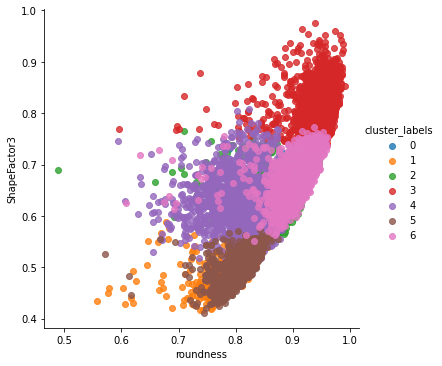

In [50]:
sns.lmplot(x='roundness',y='ShapeFactor3',data=df_pandas,hue='cluster_labels',fit_reg=False)

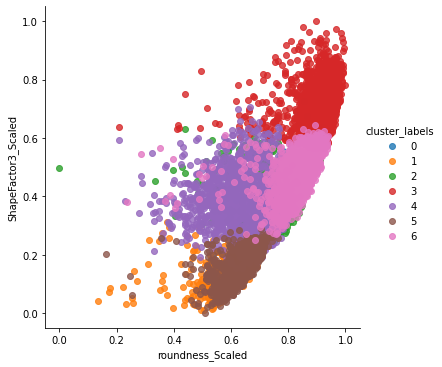

In [51]:
sns.lmplot(x='roundness_Scaled',y='ShapeFactor3_Scaled',data=df_pandas,hue='cluster_labels',fit_reg=False)

Nothing big but small differences to see with eye. Bigger performance difference when we examine the silhoutte score and accuracy metrics.

In [52]:
features_columns.append('cluster_labels')
selected_columns.append('cluster_labels')

This below code calls the all figures with all the features. This is better to notice significant relationships on the figure. As we see some features clusters the data better than the others. That shows the relationship between them. It took so much time so i did not executed them.

In [53]:
#sns.pairplot(df_pandas[features_columns],hue='cluster_labels')

In [54]:
#sns.pairplot(df_pandas[selected_columns],hue='cluster_labels')

## Modeling for Classification <a class="anchor" id="classificationmodel"></a>

Now i will do classification.For modeling i have decided to use Desicion Tree, it is easy to implement. It is similar to sklearn Desicion tree but it takes input feautures vector and output column. By doing this we dont need y_train, y_test. And in PySpark we have .fit and .transform. After this we have prediction PySpark Dataframe.

Lets start with original not normalized train and test set.

In [55]:
from pyspark.ml.classification import DecisionTreeClassifier

tree = DecisionTreeClassifier(featuresCol='features', labelCol='Label')

tree_model = tree.fit(transformed_X_train)

prediction = tree_model.transform(transformed_X_test)

I will use MulticlassClassificationEvaluator to evaluate model performance using predictions and true labels. This will give Test Error and Test Accuracy.

In [56]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


evaluator = MulticlassClassificationEvaluator(
    labelCol="Label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(prediction)
print("Test Error = %g " % (1.0 - accuracy))
print("Test Accuracy = %g " % (accuracy))

Test Error = 0.10978 
Test Accuracy = 0.89022 


Our accuracy is good, very similar to outputs i got from assignment2. Now i will try to print confusion matrix. It is the same function i have used in assignment2.

In [57]:
y_true = prediction.select(['Label']).collect()
y_pred = prediction.select(['prediction']).collect()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92      1100
         1.0       0.84      0.86      0.85       759
         2.0       0.85      0.93      0.89       597
         3.0       0.96      0.93      0.94       579
         4.0       0.92      0.82      0.87       495
         5.0       0.81      0.84      0.82       389
         6.0       1.00      0.87      0.93       171

    accuracy                           0.89      4090
   macro avg       0.90      0.88      0.89      4090
weighted avg       0.89      0.89      0.89      4090



We can see presicion, recall, f1-score, support, accuracy metrics.

Now lets see the confusion matrix. We are givint y_true and y_pred we obtained from prediction.select(['Label']).collect() as we see confusion matrix is looking good.

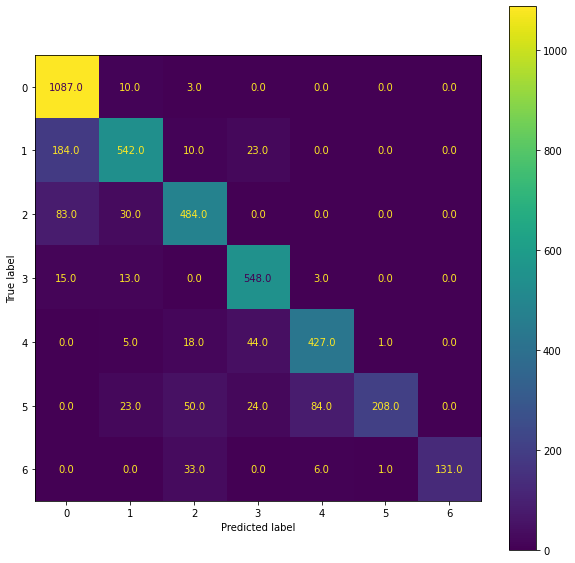

In [71]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3,4,5,6])
fig, ax = plt.subplots(figsize=(10,10))
cmd.plot(ax=ax, values_format = '.1f')

In second column i can see that label 0 is predicted too much compared to others. These two labels might be close to each other maybe thats why our desicion tree thinks they are similar and fails to recognise label1 with label0. It was original data and it is looking good for a non normalized original data.

In [59]:
tree = DecisionTreeClassifier(featuresCol='features', labelCol='Label')

tree_model = tree.fit(transformed_nX_train)

prediction = tree_model.transform(transformed_nX_test)

Lets evaulate our prediction we get from our tree using normalized x train and x test.

In [60]:

evaluator = MulticlassClassificationEvaluator(
    labelCol="Label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(prediction)
print("Test Error = %g " % (1.0 - accuracy))
print("Test Accuracy = %g " % (accuracy))

Test Error = 0.162103 
Test Accuracy = 0.837897 


In [61]:
y_true = prediction.select(['Label']).collect()
y_pred = prediction.select(['prediction']).collect()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.79      0.99      0.88      1100
         1.0       0.87      0.71      0.78       759
         2.0       0.81      0.81      0.81       597
         3.0       0.86      0.95      0.90       579
         4.0       0.82      0.86      0.84       495
         5.0       0.99      0.53      0.69       389
         6.0       1.00      0.77      0.87       171

    accuracy                           0.84      4090
   macro avg       0.88      0.80      0.83      4090
weighted avg       0.85      0.84      0.83      4090



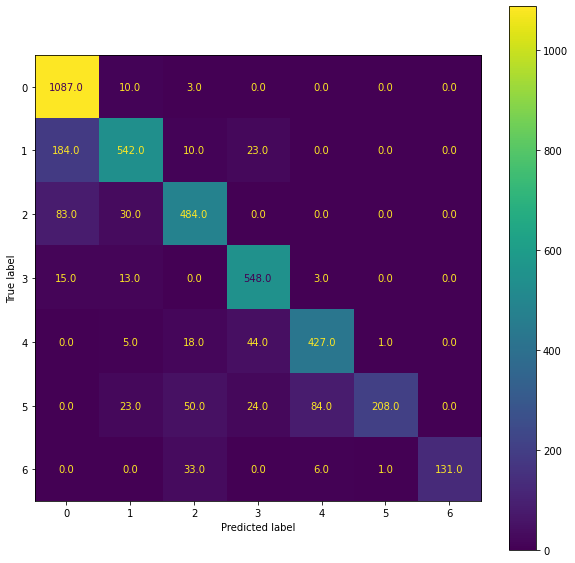

In [72]:
cm = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3,4,5,6])
fig, ax = plt.subplots(figsize=(10,10))
cmd.plot(ax=ax, values_format = '.1f')

## Evaluation<a class="anchor" id="evaluation"></a>

Desicion Tree Original : 
Test Accuracy = 0.889219 
Desicion Tree Normalized : 
Test Accuracy = 0.859298 

This result is confusing because we get worse results in classifying with normalized data. Normally this is not normal but i think this is because of using desicion tree model. After some search normalization is not always mandatory. If our inputs include an irrelevant feature then un-normalized input may give a better answer.

I have also tried some other machine learning classification methods but they were failed de converge and their acc was around %25 so i did not include them in this assignment.

Also my final opinions on PySpark is it is diffucult to use compared to sklearn, pandas but when we deal with big data and we need parallelization, we must use Pyspark because it is utilized to deal with big data. Visualising, clustering is harder but pipelining and classification seems equal or better.




## References<a class="anchor" id="references"></a>


https://stats.stackexchange.com/questions/343106/worse-accuracy-with-input-normalization-nns

https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.describe.html

https://www.geeksforgeeks.org/adding-new-column-to-existing-dataframe-in-pandas/

https://stackoverflow.com/questions/42154476/spark-join-raises-detected-cartesian-product-for-inner-join/51815018

https://stackoverflow.com/questions/44762353/why-does-spark-fail-with-detected-cartesian-product-for-inner-join-between-logi/44762495

https://stackoverflow.com/questions/50958721/convert-a-spark-dataframe-to-pandas-df

https://stackoverflow.com/questions/56858203/pyspark-self-join-with-error-resolved-attributes-missing

https://stackoverflow.com/questions/45713290/how-to-resolve-the-analysisexception-resolved-attributes-in-spark/53848160

https://forums.databricks.com/questions/6920/pyspark-dataframe-select-all-but-one-or-a-set-of-c.html

https://stackoverflow.com/questions/50399361/duplicate-a-column-in-pyspark-data-frame

https://sparkbyexamples.com/pyspark/select-columns-from-pyspark-dataframe/

https://www.quora.com/Why-does-the-accuracy-decreases-after-I-did-data-normalization-in-CNN-model